<a href="https://colab.research.google.com/github/L-Gaysina/Emotion_recognithon/blob/main/Emotion_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Сервис оценки эмоций пациента по тону голоса на приёме у врача
<hr>


Над проектом работали:
Команда № 2 **'C.D.C'.**

0. Кириленков Кирилл Владимирович

0. Корзун Иван Анатольевич

0. Хван Ок Хи

0. Федеряев Клим Александрович

0. Гайсина Лиана Ильдаровна




<hr>



Для более комфортной работы включите в блокноте GPU и запустите все ячейки с начала:

```
Среда выполнения > Сменить среду выполнения > Аппаратный ускоритель > GPU > Сохранить
---
Runtime > Change runtime type > Hardware accelerator > GPU > Save
```

In [ ]:
# Установка дополнительных модулей
%pip install -q mplcyberpunk wave

# Импорт дополнительных модулей
import torch
import matplotlib.pyplot as plt
import mplcyberpunk
import soundfile as sf
from transformers import HubertForSequenceClassification, Wav2Vec2FeatureExtractor
import torchaudio
import wave
import numpy as np

In [ ]:
# @title Загрузите ваш речевой аудиофайл
# @markdown ### Загружайте только аудио файлы в формате .wav или .ogg
# @markdown ### не короче 15 секунд!
# @markdown ########################################################
# @markdown ### Быстро раздобыть файл формата .ogg для тестирования
# @markdown ###  можно с помощью скачивания аудиосообщения из ТГ

from google.colab import files
result = files.upload()
file_name, value = list(result.items())[0]

# Если загрузился файл .ogg, то он будет переконвертирован в .wav

if '.ogg' in file_name:
    data, samplerate = sf.read(file_name)
    file_name = file_name[0:-4] + '.wav'
    sf.write(file_name, data, samplerate)
    print(file_name)


Saving instruction1.wav to instruction1.wav


In [ ]:
# @title Этот фрагмент кода разделяет исходный файл на N частей.
# Количество сегментов
N = 5

def segmentator(N_segments: int, f_name: str):

    with wave.open(f_name, "rb") as infile:
            # get file data
        nchannels = infile.getnchannels()
        sampwidth = infile.getsampwidth()
        framerate = infile.getframerate()
        frames = infile.getnframes()
        duration = frames / float(framerate)
        print(f'Продолжительность загруженного файла: {round(duration, 2)} сек. \n')
        segment = duration / N
        segments = [i * segment for i in range(N + 1)]

        for i in range(len(segments) - 1):

            # set position in wave to start of segment
            infile.setpos(int(segments[i] * framerate))
            # extract data
            data = infile.readframes(int((segments[i + 1] - segments[i]) * framerate))

            # write the extracted data to a new file
            with wave.open(f'{i}_output.wav', 'w') as outfile:
                outfile.setnchannels(nchannels)
                outfile.setsampwidth(sampwidth)
                outfile.setframerate(framerate)
                outfile.setnframes(int(len(data) / sampwidth))
                outfile.writeframes(data)
                print(str(outfile))

segmentator(N, file_name)

Продолжительность загруженного файла: 47.93 сек. 



In [ ]:
# Загрузка в предобученной модели

feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("facebook/hubert-large-ls960-ft")
model = HubertForSequenceClassification.from_pretrained("xbgoose/hubert-speech-emotion-recognition-russian-dusha-finetuned")
num2emotion = {0: 'neutral', 1: 'angry', 2: 'positive', 3: 'sad', 4: 'other'}

preprocessor_config.json:   0%|          | 0.00/212 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.80k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

Some weights of the model checkpoint at xbgoose/hubert-speech-emotion-recognition-russian-dusha-finetuned were not used when initializing HubertForSequenceClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at xbgoose/hubert-speech-emotion-recognition-russian-dusha-finetuned and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametri

In [ ]:
# Инициализация итогового словаря

result_dict = {}

# Обработка фрагметов загруженного файла в цикле с помощью модели

print('Краткий вывод модели по каждому сегменту \n')

for i in range(N):

    filepath = f'{i}_output.wav'
    waveform, sample_rate = torchaudio.load(filepath, normalize=True)
    transform = torchaudio.transforms.Resample(sample_rate, 16000)
    waveform = transform(waveform)

    inputs = feature_extractor(
            waveform,
            sampling_rate=feature_extractor.sampling_rate,
            return_tensors="pt",
            padding=True,
            max_length=16000 * 10,
            truncation=True
        )

    logits = model(inputs['input_values'][0]).logits
    del(inputs)
    del(transform)
    predictions = torch.argmax(logits, dim=1)
    predicted_emotion = num2emotion[predictions.numpy()[0]]
    print(f'segment {i} dominant emotion: ' + predicted_emotion)

    # Инициализация внутреннего словаря
    # и добавление его в итоговый словарь result_dict

    result_dict[filepath] = {}
    for num, emotion in num2emotion.items():
        result_dict[filepath][emotion] = logits[0][num].item()

Краткий вывод модели по каждому сегменту 

segment 0 dominant emotion: neutral
segment 1 dominant emotion: neutral
segment 2 dominant emotion: neutral
segment 3 dominant emotion: neutral
segment 4 dominant emotion: neutral


In [ ]:
print(result_dict)

{'0_output.wav': {'neutral': 4.302017688751221, 'angry': -0.3316851258277893, 'positive': 1.937193751335144, 'sad': -3.812793493270874, 'other': -3.7984189987182617}, '1_output.wav': {'neutral': 4.502582550048828, 'angry': -1.0206730365753174, 'positive': 1.3206418752670288, 'sad': -2.6701061725616455, 'other': -4.0197906494140625}, '2_output.wav': {'neutral': 2.504694700241089, 'angry': 1.0109891891479492, 'positive': 1.6592084169387817, 'sad': -1.9862430095672607, 'other': -4.271965503692627}, '3_output.wav': {'neutral': 3.1593685150146484, 'angry': 2.495014190673828, 'positive': 0.18108198046684265, 'sad': -3.028146982192993, 'other': -3.863001823425293}, '4_output.wav': {'neutral': 3.950469970703125, 'angry': -0.24539382755756378, 'positive': 0.32094037532806396, 'sad': -1.18526291847229, 'other': -4.582486629486084}}


In [ ]:
# Отформатированный вывод итогового словаря c подробными
# нормированными на 0 значениями
print('Подробный вывод модели по каждому сегменту \n')
for k, v in result_dict.items():
    print(f'{k}: {v}')

Подробный вывод модели по каждому сегменту 

0_output.wav: {'neutral': 4.302017688751221, 'angry': -0.3316851258277893, 'positive': 1.937193751335144, 'sad': -3.812793493270874, 'other': -3.7984189987182617}
1_output.wav: {'neutral': 4.502582550048828, 'angry': -1.0206730365753174, 'positive': 1.3206418752670288, 'sad': -2.6701061725616455, 'other': -4.0197906494140625}
2_output.wav: {'neutral': 2.504694700241089, 'angry': 1.0109891891479492, 'positive': 1.6592084169387817, 'sad': -1.9862430095672607, 'other': -4.271965503692627}
3_output.wav: {'neutral': 3.1593685150146484, 'angry': 2.495014190673828, 'positive': 0.18108198046684265, 'sad': -3.028146982192993, 'other': -3.863001823425293}
4_output.wav: {'neutral': 3.950469970703125, 'angry': -0.24539382755756378, 'positive': 0.32094037532806396, 'sad': -1.18526291847229, 'other': -4.582486629486084}


# Обработка результатов и визуализация

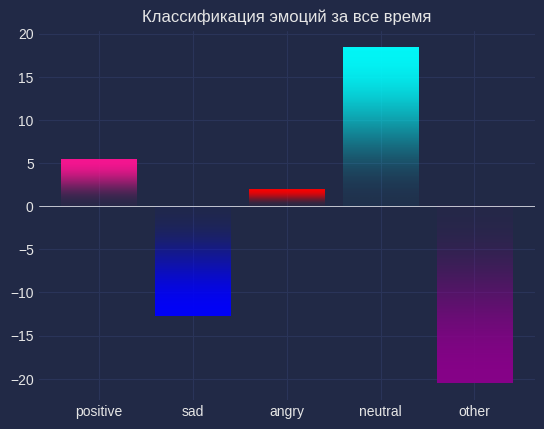

In [ ]:
# @title Классификация эмоций за все время. Суммирует все эмоции на всех фрагментах исходного файла
# Создаем словарь для подсчета эмоций
emotion_counts = {'positive': 0, 'sad': 0, 'angry': 0, 'neutral': 0, 'other': 0}

# Подсчитываем количество каждой эмоции
for res in result_dict.values():
    for emotion, value in res.items():
        if emotion in ['positive']:
            emotion_counts['positive'] += value
        elif emotion in [ 'sad']:
            emotion_counts['sad'] += value
        elif emotion == 'angry':
            emotion_counts['angry'] += value
        elif emotion == 'neutral':
            emotion_counts['neutral'] += value
        elif emotion == 'other':
            emotion_counts['other'] += value

# Создаем списки для графика
emotions = list(emotion_counts.keys())
counts = list(emotion_counts.values())

# Определяем цвета для каждой эмоции
color_mapping = {
    'angry': '#FF0000',
    'positive': '#FF1493',
    'other': '#8B008B',
    'neutral': '#00FFFF',
    'sad': '#0000FF'
}

# Список цветов для графика
colors = [color_mapping[emotion] for emotion in emotions]

# Используем стиль 'cyberpunk' для графика
plt.style.use('cyberpunk')
bars = plt.bar(emotions, counts, color=colors)
mplcyberpunk.add_bar_gradient(bars=bars)

# Добавляем линии координатной оси x
plt.axhline(0, color='white', linewidth=0.5)

# Устанавливаем заголовок графика
plt.title('Классификация эмоций за все время')

# Отображаем график
plt.show()

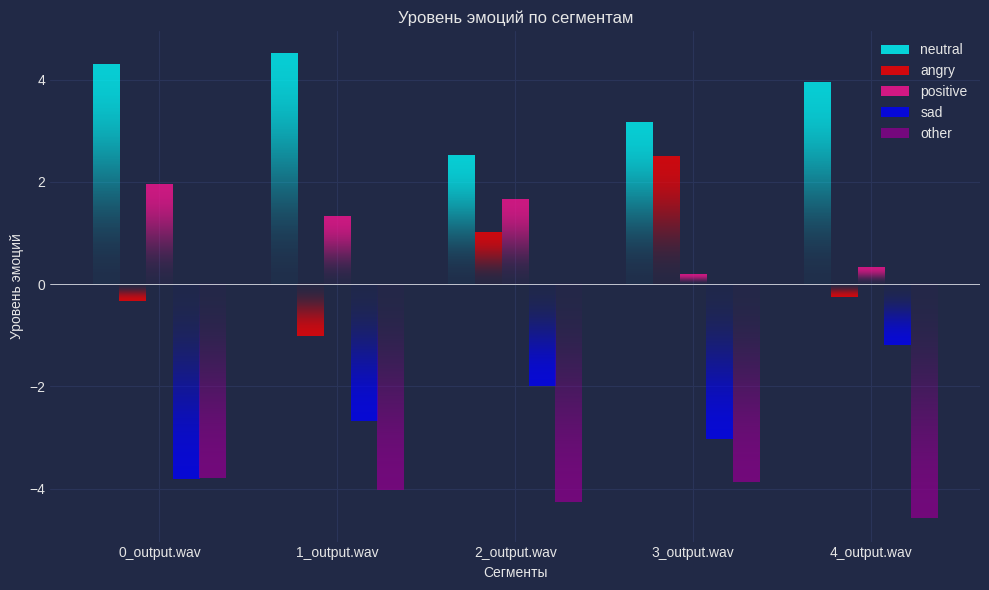

In [ ]:
# @title График эмоциональной динамики по фрагментам аудио файла Вариант 1
segments = []
emotions = list(result_dict[list(result_dict.keys())[0]].keys())
emotion_levels = [[] for _ in range(len(emotions))]

for segment, emotions_dict in result_dict.items():
    segments.append(segment)

    for j, emotion in enumerate(emotions):
        emotion_levels[j].append(emotions_dict[emotion])

# Создание графика
plt.style.use('cyberpunk')

fig, ax = plt.subplots(figsize=(10, 6))

# Создание словаря с цветами для каждой эмоции
color_mapping = {
    'angry': '#FF0000',
    'positive': '#FF1493',
    'other': '#8B008B',
    'neutral': '#00FFFF',
    'sad': '#0000FF'
}

# Рассчитываем ширину столбцов и смещение для каждой эмоции
num_emotions = len(emotions)
bar_width = 0.15
index = np.arange(len(segments))
opacity = 0.8

# Создание группированного графика гистограмм
for i in range(num_emotions):
    offset = i * bar_width - (bar_width * (num_emotions - 1)) / 2

    rect = ax.bar(index + offset, emotion_levels[i], bar_width,
                  alpha=opacity,
                  color=color_mapping[emotions[i]],  # Использование цвета из словаря color_mapping
                  label=emotions[i])

# Настройка осей и меток
ax.set_xlabel('Сегменты')
ax.set_ylabel('Уровень эмоций')
ax.set_title('Уровень эмоций по сегментам')
ax.set_xticks(index)
ax.set_xticklabels(segments)
ax.legend()

# Добавляем градиент на столбцы
for container in ax.containers:
    mplcyberpunk.add_bar_gradient(bars=container)
# Добавляем линии координатной оси x
plt.axhline(0, color='white', linewidth=0.5)

plt.tight_layout()
plt.show()

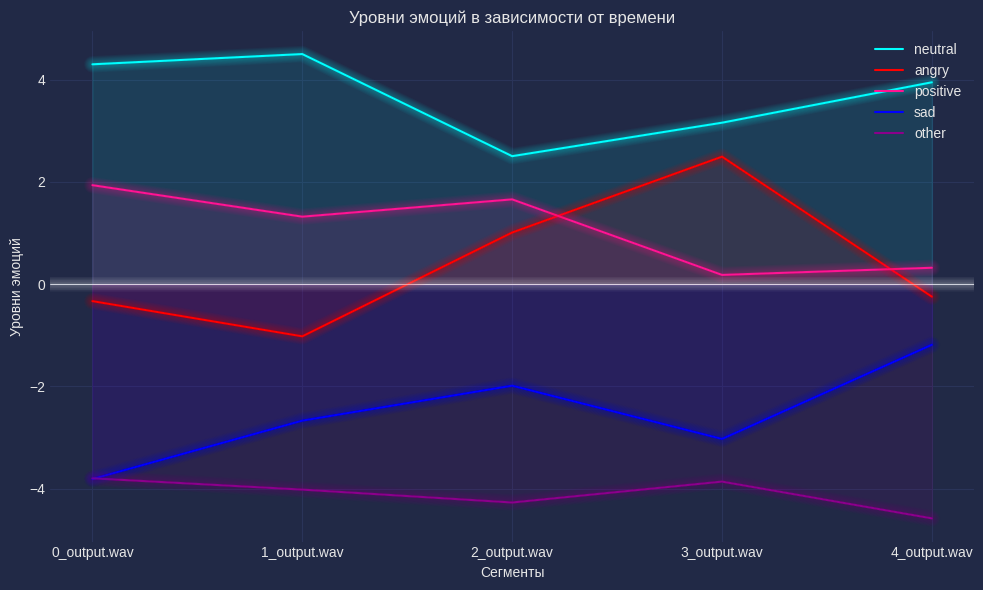

In [ ]:
# @title График эмоциональной динамики по фрагментам аудио файла Вариант 2
segments = []
emotions = list(result_dict[list(result_dict.keys())[0]].keys())
emotion_levels = [[] for _ in range(len(emotions))]

segments = list(result_dict.keys())

for segment, emotions_dict in result_dict.items():
    for j, emotion in enumerate(emotions):
        emotion_levels[j].append(emotions_dict[emotion])

# Создание графика
plt.style.use('cyberpunk')

fig, ax = plt.subplots(figsize=(10, 6))

# Создание словаря с цветами для каждой эмоции
color_mapping = {
    'angry': '#FF0000',
    'positive': '#FF1493',
    'other': '#8B008B',
    'neutral': '#00FFFF',
    'sad': '#0000FF'
}

# Построение графика эмоций в зависимости от времени
for i, emotion in enumerate(emotions):
    ax.plot(segments, emotion_levels[i], color=color_mapping[emotion], label=emotion)

# Настройка осей и меток
ax.set_xlabel('Сегменты')
ax.set_ylabel('Уровни эмоций')
ax.set_title('Уровни эмоций в зависимости от времени')
ax.legend(loc='upper right')

# Добавление линии оси x
plt.axhline(0, color='white', linewidth=0.5)
mplcyberpunk.add_glow_effects()
plt.tight_layout()
plt.show()

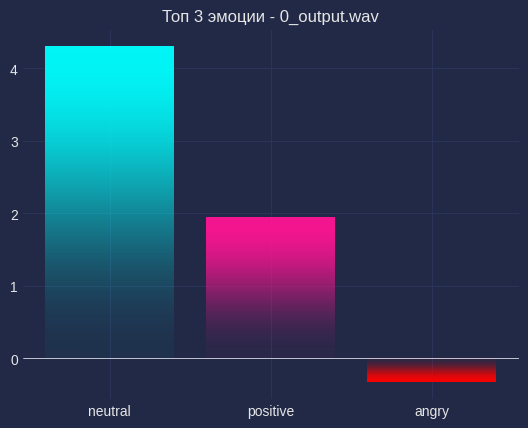

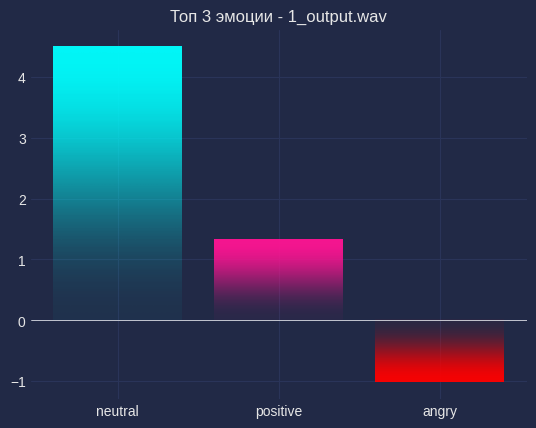

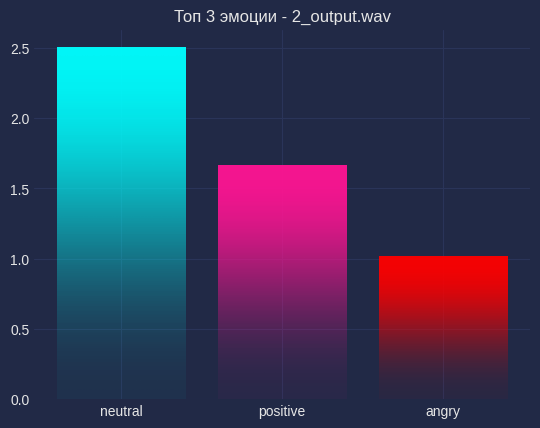

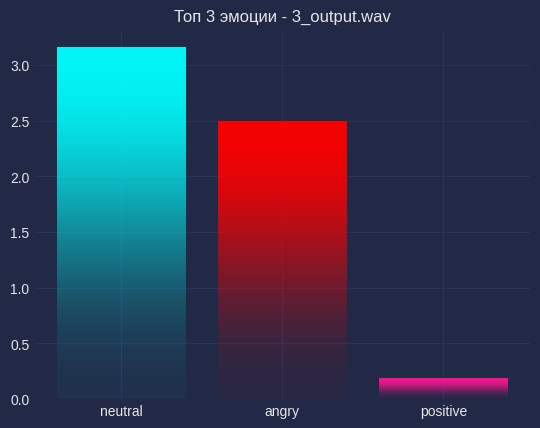

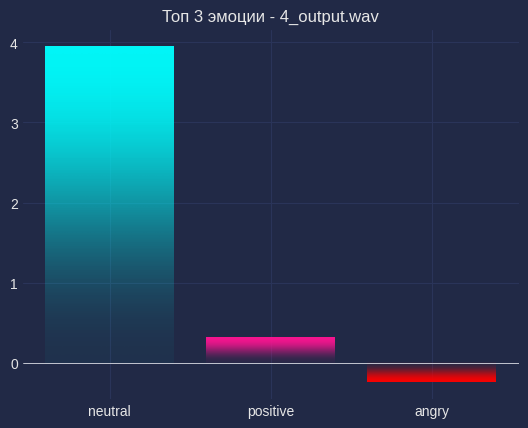

In [ ]:
# @title  "Топ-3 Эмоции" для каждого фрагмента записи отдельно

for key, value in result_dict.items():
    # Получаем эмоции и вероятности из словаря результатов
    emotions, probabilities = zip(*value.items())

    # Сортируем эмоции по убыванию вероятностей
    sorted_emotions = [emotion for _, emotion in sorted(zip(probabilities, emotions), reverse=True)]
    sorted_probabilities = sorted(probabilities, reverse=True)

    # Выбираем три наибольших значения эмоций
    top_emotions = sorted_emotions[:3]
    top_probabilities = sorted_probabilities[:3]

    # Построим гистограмму
    # Создаем словарь с соответствием цветов эмоциям
    color_mapping = {
        'angry': '#FF0000',
        'positive': '#FF1493',
        'other': '#8B008B',
        'neutral': '#00FFFF',
        'sad': '#0000FF'
    }

    # Получаем список цветов для каждой эмоции из топ-3
    colors = [color_mapping[emotion] for emotion in top_emotions]

    # Используем стиль 'cyberpunk' для графика
    plt.style.use('cyberpunk')
    bars = plt.bar(range(len(top_emotions)), top_probabilities, color=colors)
    mplcyberpunk.add_bar_gradient(bars=bars)

    # Устанавливаем заголовок графика
    plt.title(f'Топ 3 эмоции - {key}')

    # Устанавливаем подписи осей x
    plt.xticks(range(len(top_emotions)), top_emotions)

    # Добавляем линию координатной оси x
    plt.axhline(0, color='white', linewidth=0.5)

    # Отображаем график
    plt.show()
    print()